### Extract Phenotypes for OTC project

The phenotype data from plate images in the OTC project was extracted by running the cells of code in this notebook. First, necessary python packages are imported and helper functions are defined. Then a list is constructed constituting the relevant image files to be processed. Finally,the images are processed, exporting the data for patch areas and raw integral densities (as a proxy for volume) .csv file. Throughout this process, images for which the default cropping method failed are skipped. At the end, unprocessed images are identified by comparing the list of input images with the list of output files. Missing images were revisited with alternative crop locations manually provided in lines 11-13 of the cell containing the main processing loop.

### 1. Load Packages and define functions

In [4]:
# Load Packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from PIL import Image
from skimage import feature, filters, data, color, io
import skimage
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage.draw import circle
from scipy.signal import find_peaks
from IPython.display import clear_output
import collections

import sys
sys.path.append('./')
from skimage.filters import sobel
from scipy.signal import find_peaks
from pathlib import Path
import glob
import os
import shutil
import pandas as pd
from skimage.exposure import histogram

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from shutil import copy2
from PIL import Image
from PIL.ExifTags import TAGS

# Define Functions for loading and processing images


def LoadPlateImages(folder):
    '''
    Imports all jpg images in the working directory and places them in a list
    '''
    path = Path(os.getcwd() + '\\' + folder)
    images = [skimage.io.imread(file) for file in path.glob("*.jpg")]
    files = os.listdir(path)
    return images, files

def ListImageFiles(folder):
    '''
    Imports all jpg images in the working directory and places them in a list
    '''
    path = Path(os.getcwd() + '\\' + folder)
    files = os.listdir(path)
    return files

def ListFiles(folder):
    '''
    Imports all jpg images in the working directory and places them in a list
    '''
    path = Path(os.getcwd() + '\\' + folder)
    files = os.listdir(path)
    return files

def CropPlateImage(cell_plate_image, display=False):
    '''
    Input: RGB or grayscale image of rectangular arrayed plate.
    Returns: Ordered list of subsections of the image containing a single colony, 
                or blanks if there are empty spots in the array.
    '''
    # Convert to gray_scale if necessary. Return a message if image is in unexpected format.
    if len(np.shape(cell_plate_image))==3:
        cell_plate_gray = skimage.color.rgb2gray(cell_plate_image)
    elif len(np.shape(cell_plate_image))==2:
        cell_plate_gray = cell_plate_image
    else:
        print("Input image must be grayscale or RGB.")
        
    # Crop to plate by identifying abrupt change from black background to plate edge.    
     
    #x = np.sum(cell_plate_gray[1000:2000,:], axis = 0)
    #idx_0= np.argwhere(x>700);
    x = np.sum(cell_plate_gray[:,:], axis = 0)
    idx_0= np.argwhere(x>1200);
    diff_idx_0 = np.argmax(np.diff(idx_0.T)); 
    crop_idx_0 = idx_0[diff_idx_0:diff_idx_0 + 2]
    if display == True:
        plt.plot(x)
        plt.axhline(y=1200, color='r', linestyle = '--')

    temp_g = (cell_plate_gray[:,np.int(crop_idx_0[0]):np.int(crop_idx_0[1])])

    y = np.sum(temp_g[1000:2000,:], axis = 0)
    x = np.sum(temp_g[:,:], axis = 1)
    peaks_x, _ = find_peaks(x, width = 60, distance = 100, height=150, threshold = np.array([0,7]))
    peaks_y, _ = find_peaks(y,  width = 60, distance = 100, height=150, threshold = np.array([0,7]))

    if display == True:
        print(peaks_x, peaks_y)
    buffer_x = np.min(peaks_x[1:-1]-peaks_x[0:-2]); buffer_y = np.min(peaks_y[1:-1]-peaks_y[0:-2])
    crop_locs_x = peaks_x + int(buffer_x/2); crop_locs_x = np.append(peaks_x[0] - int(buffer_x/2),crop_locs_x)
    crop_locs_y = peaks_y + int(buffer_x/2); crop_locs_y = np.append(peaks_y[0] - int(buffer_x/2),crop_locs_y)

    if display == True:
        fig, axs = plt.subplots(1, 2, figsize=(9,3))
        axs[0].plot(x)
        axs[0].plot(peaks_x, x[peaks_x],'rx')
        for xc in crop_locs_x:
            axs[0].axvline(x=xc, color='g',linestyle='--')
        axs[1].plot(y)
        axs[1].plot(peaks_y, y[peaks_y],'rx')
        for xc in crop_locs_y:
            axs[1].axvline(x=xc, color='g',linestyle='--')
    
    # Return list of grayscale and color tiles
    tiles = []
    for j in range(0,len(crop_locs_x)-1):
        row = temp_g[np.int(crop_locs_x[j]):np.int(crop_locs_x[j+1]):1,:]
        for jj in range(0,len(crop_locs_y)-1):
            cropped_section = row[:,np.int(crop_locs_y[jj]):np.int(crop_locs_y[jj+1]):1]
            tiles.append(cropped_section)
            
    tiles = tiles[0:96]
    return tiles

def DisplayTiles(tile_list):
    fig, axs = plt.subplots(8, 12,figsize=(12,8))
    count = 0
    for j in range(0,8):
        for jj in range(0,12):
            axs[j,jj].imshow(tile_list[count])
            axs[j,jj].axis('off')
            count = count + 1
    plt.show();
    
def MergeTiles(tiles, crop_locs_x, crop_locs_y):
          
    crop_locs_x = crop_locs_x - crop_locs_x[0]
    crop_locs_y = crop_locs_y - crop_locs_y[0]
    img = np.zeros((crop_locs_x[-1],crop_locs_y[-1],3))
    count = 0
    for i in range(0,8):
        for j in range(0,12):
            img[crop_locs_x[i]:crop_locs_x[i+1],crop_locs_y[j]:crop_locs_y[j+1],:] = tiles[count]
            count = count + 1
    return img
    
def SizeFeatures(clean_tile_list, colony_mask_list, tile_list):
    area_list = []
    pixel_sum_list = []
    perimeter_list = []
    #background_list = []
    check_list = []
    for j in range(0,len(clean_tile_list)):
        mask = colony_mask_list[j]
        clean_tile = clean_tile_list[j]
        colony_area = np.sum(mask)
        area_list.append(colony_area)
        pixel_sum_list.append(np.sum(clean_tile))  
        perimeter_list.append(skimage.measure.perimeter(mask))
        #background_list.append(np.median(tile_list[j][0:20,0:200]))
    
    #background = np.mean(background_list) 
    background = 0
    intden_list = [pixel_sum -background*area for pixel_sum,area in zip(pixel_sum_list,area_list)]
                                   
    return area_list, pixel_sum_list, intden_list, perimeter_list, background
def TextureFeatures(intden_list,colony_masks, clean_tiles):
    LBP_list = ([mask*skimage.feature.local_binary_pattern(tile, 8, 10, method='uniform') 
                 for (mask,tile) in zip(colony_masks,clean_tiles)])
    score = np.zeros((96,10)) 
    for j in range(0, 96):
        if area_list[j]>0:
            LBP_t = LBP_list[j]
            hist, hist_centers = histogram(LBP_t[colony_masks[j]])
            temp = hist[hist>0]/area_list[j]
            score[j,:] = temp
        else:
            score[j,:] = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        
    return LBP_list, score

def SegmentTiles(tiles, min_radii=28, max_radii=40, Display=False):
    if Display:
        DisplayTiles(tiles)
    
    colony_masks = []
    clean_tiles = []
    tile_thresh = []
    labeled_image = []
    background_list = [np.median(t[0:20,0:200]) for t in tiles]
    background = np.mean(background_list)
    #print(background)
    
    count = 0

    for m in tiles:
        count = count + 1    
        t1 = np.copy(m)
        
        if count == 96:
            t1 = t1[0:160,0:160]

        thresh = threshold_otsu(t1)
        bw = closing(t1 > thresh, square(1))
        bw = ndi.binary_fill_holes(bw)
        label_image = label(bw)

        colony_mask2 = 1*label_image - 1*clear_border(label_image) 

        t = np.copy(t1)
        t[colony_mask2>0] = background
        thresh = threshold_otsu(t)
        bw = closing(t > thresh, square(4)) 
        bw = ndi.binary_fill_holes(bw)
        label_image = label(bw)

        label_objects, nb_labels = ndi.label(label_image>0)
        # Select largest object
        sizes = np.bincount(label_objects.ravel())
        mask_sizes = sizes > 2000
        mask_sizes[0] = 0
        colony_mask_temp = mask_sizes[label_objects]
        # remove artifacts connected to image border
        colony_mask = clear_border(colony_mask_temp)
        
        if thresh< 0.55:
            # Try again, adjusting threshold away from agar
            thresh = threshold_otsu(t1)
            bw = closing(t1 > thresh+0.01, square(1))
            bw = ndi.binary_fill_holes(bw)
            label_image = label(bw)

            colony_mask2 = 1*label_image - 1*clear_border(label_image) 

            t = np.copy(t1)
            t[colony_mask2>0] = background
            thresh = threshold_otsu(t)
            bw = closing(t > thresh+0.01, square(1)) 
            bw = ndi.binary_fill_holes(bw)
            label_image = label(bw)

            label_objects, nb_labels = ndi.label(label_image>0)
            # Select largest object
            sizes = np.bincount(label_objects.ravel())
            mask_sizes = sizes > 2000
            mask_sizes[0] = 0
            colony_mask_temp = mask_sizes[label_objects]
            # remove artifacts connected to image border
            colony_mask = clear_border(colony_mask_temp)
            
            # Detect circle (corresponding to initial pin if colony is faint)
            try:
                edge2 = skimage.feature.canny(colony_mask, sigma = 0.25)
                hough_radii = np.arange(min_radii,max_radii, 0.5)
                hough_res = hough_circle(edge2, hough_radii)
                centers = []
                accums = []
                radii = []
                for radius, h in zip(hough_radii, hough_res):
                    # For each radius, extract one circle
                    peaks = peak_local_max(h, num_peaks=1)
                    centers.extend(peaks)
                    accums.extend(h[peaks[:, 0],peaks[:,1]])
                    radii.extend([radius])

                # Pick the most prominent circle for mask
                    if np.max(accums) > 0.1:
                        idx = np.argmax(accums)
                        center_x, center_y = centers[idx]
                        radius = radii[idx]+1
                        cx, cy = circle(center_x, center_y, radius)
                        colony_mask = np.zeros_like(t)
                        try:
                            colony_mask[cx,cy] = 1
                        except:
                            pass
                        colony_mask = colony_mask>0
                    else:
                        colony_mask = np.zeros_like(t)
                        colony_mask = colony_mask>0

            except:
                try:
                    edge2 = 1*(t>np.mean(t)+.02)
                    hough_radii = np.arange(min_radii,max_radii, 0.5)
                    hough_res = hough_circle(edge2, hough_radii)
                    centers = []
                    accums = []
                    radii = []
                    for radius, h in zip(hough_radii, hough_res):
                        # For each radius, extract one circle
                        peaks = peak_local_max(h, num_peaks=1)
                        centers.extend(peaks)
                        accums.extend(h[peaks[:, 0],peaks[:,1]])
                        radii.extend([radius])

                    # Pick the most prominent circle for mask
                    if np.max(accums) > 0.1:
                        idx = np.argmax(accums)
                        center_x, center_y = centers[idx]
                        radius = radii[idx]+1
                        cx, cy = circle(center_x, center_y, radius)
                        colony_mask = np.zeros_like(t)
                        try:
                            colony_mask[cx,cy] = 1
                        except:
                            pass
                        colony_mask = colony_mask>0
                    else:
                        colony_mask = np.zeros_like(t)
                        colony_mask = colony_mask>0
                except: 
                    print("colony empty")
                    colony_mask = np.zeros_like(t)

        # Combine with thresholding result if the colony is not completely null
        elif thresh> 0.55: #0.35 #.42
            label_objects, nb_labels = ndi.label(1*((label_image)>0))

            # Select largest object
            sizes = np.bincount(label_objects.ravel())
            mask_sizes = sizes > 2000
            mask_sizes[0] = 0
            colony_mask_temp = mask_sizes[label_objects]
            # remove artifacts connected to image border
            colony_mask = clear_border(colony_mask_temp) 
            # check that colony wasn't touching image border
            if abs(np.sum(1*colony_mask)) == 0:
                try:
                    edge2 = 1*(t>np.mean(t)+.02)
                    hough_radii = np.arange(min_radii,max_radii, 0.5)
                    hough_res = hough_circle(edge2, hough_radii)
                    centers = []
                    accums = []
                    radii = []
                    for radius, h in zip(hough_radii, hough_res):
                        # For each radius, extract one circle
                        peaks = peak_local_max(h, num_peaks=1)
                        centers.extend(peaks)
                        accums.extend(h[peaks[:, 0],peaks[:,1]])
                        radii.extend([radius])

                    # Pick the most prominent circle for mask
                    idx = np.argmax(accums)
                    center_x, center_y = centers[idx]
                    radius = radii[idx]+1
                    cx, cy = circle(center_x, center_y, radius)
                    colony_mask = np.zeros_like(t)
                    try:
                        colony_mask[cx,cy] = 1
                    except:
                        pass
                    colony_mask = colony_mask>0
                except: 
                    print("colony empty")
                    colony_mask = np.zeros_like(t)

                
        if count == 96:
            colony_mask_temp = np.zeros_like(m);
            colony_mask_temp[0:160,0:160] = np.copy(colony_mask)
            colony_mask = np.copy(colony_mask_temp)
            
        image_label_overlay = label2rgb(colony_mask, image=m, bg_label=0)
        colony_masks.append(colony_mask)
        clean_tiles.append(m*colony_mask)
        tile_thresh.append(thresh)
        labeled_image.append(image_label_overlay)

    if Display:
        plt.imshow(M)
        
    
    return colony_masks, clean_tiles, labeled_image, tile_thresh

### 2. Set input and output folders

In [5]:
# -- Set input folder and list jpg files
os.chdir(r'C:\Users\Katherine\Desktop')
file_list = ListImageFiles('OTCimages')
my_list = [x  for x in file_list if "jpg"or"JPG" in x]
os.chdir(r'C:\Users\Katherine\Desktop\OTCimages')
positions = ([x+y for x in ['A','B','C','D','E','F','G','H'] 
                        for y in ['1','2','3','4','5','6','7','8','9','10','11','12']])
output_folder = r'C:\Users\Katherine\Desktop\OTCoutput'

%matplotlib inline

### 3. Process all images with initial guess for crop locations

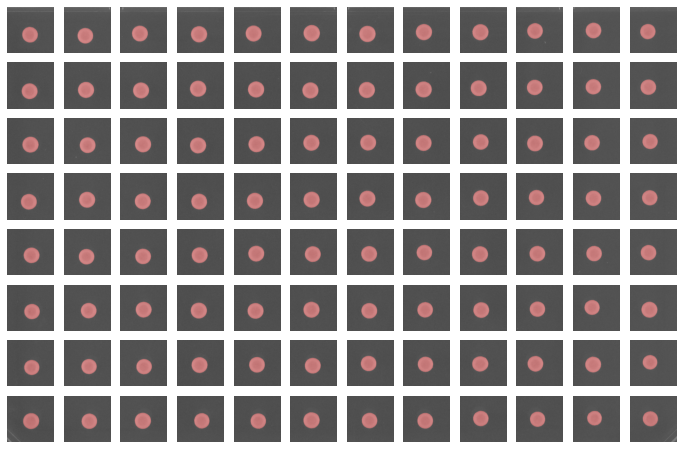

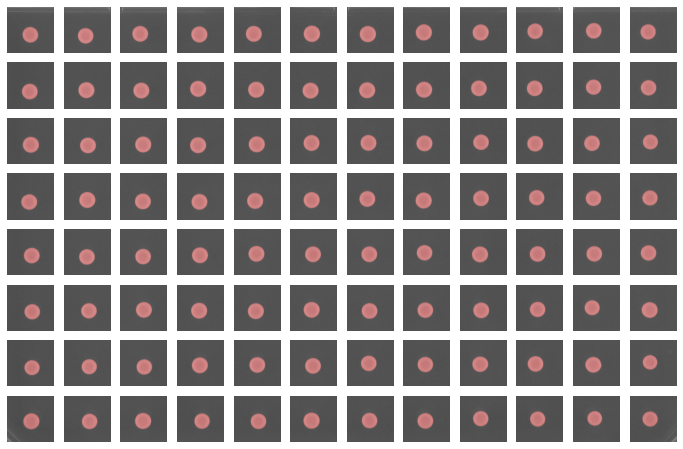

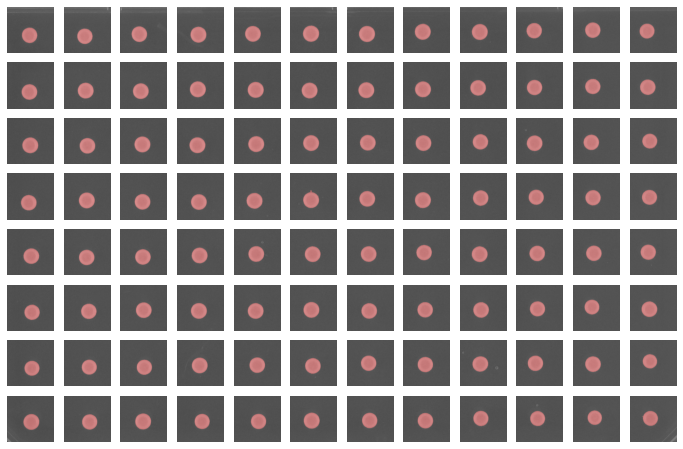

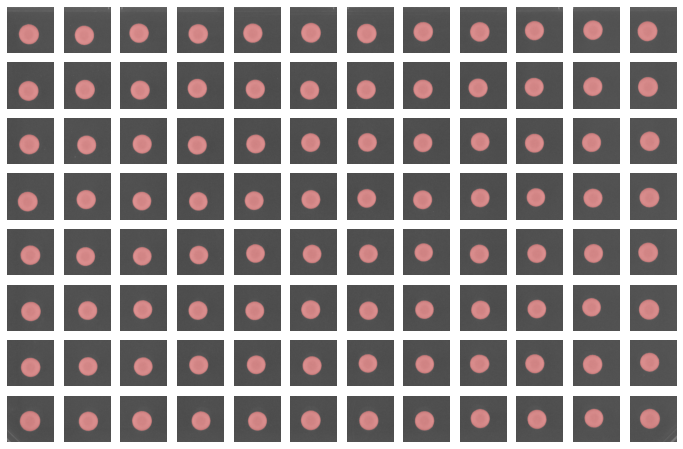

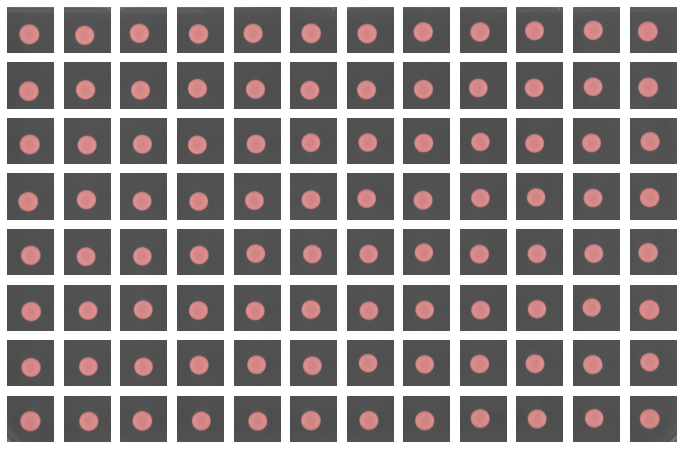

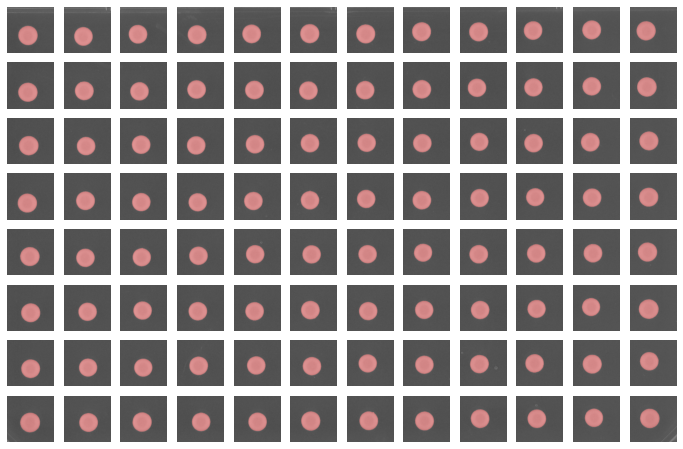

C:\Users\Katherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:270: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
C:\Users\Katherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:301: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19


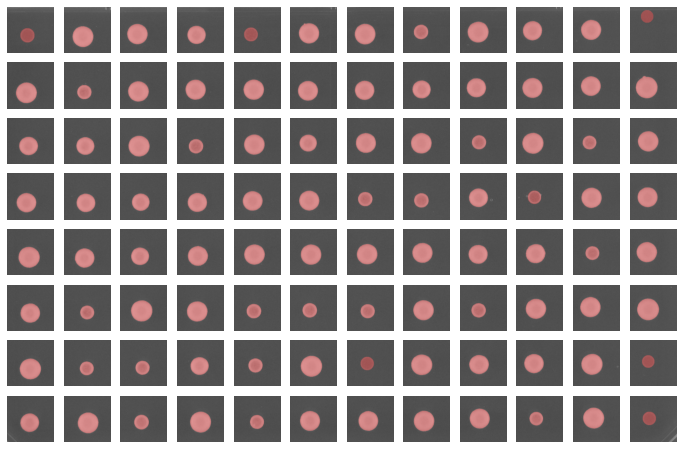

colony empty


C:\Users\Katherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


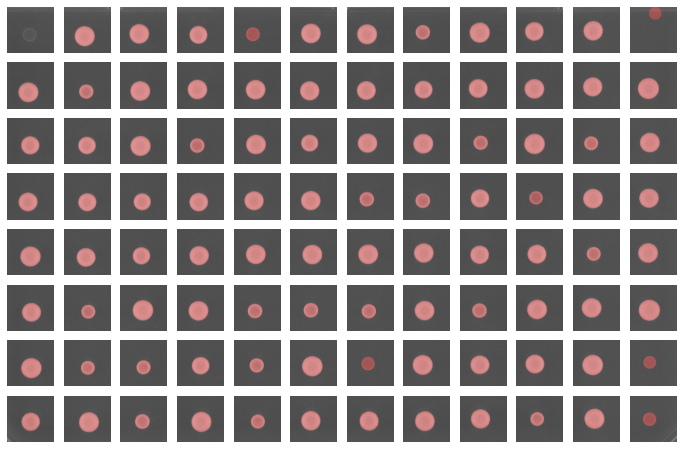

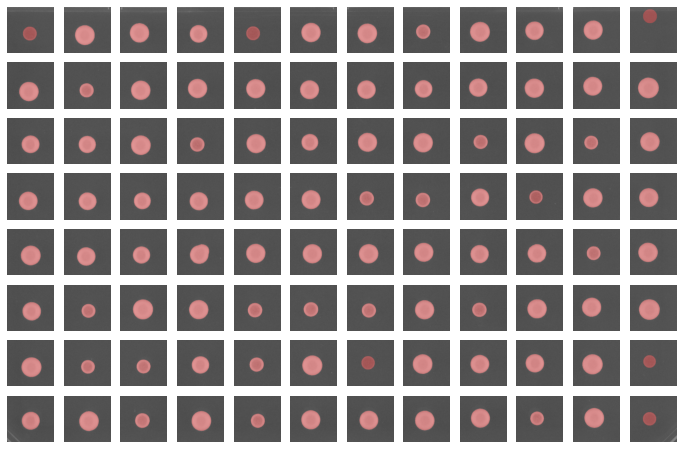

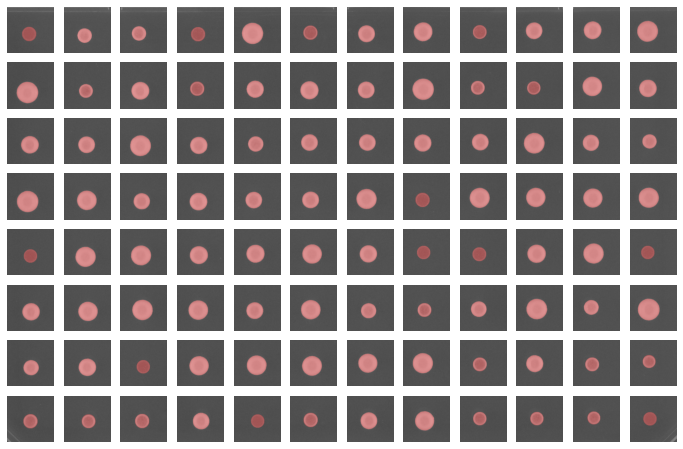

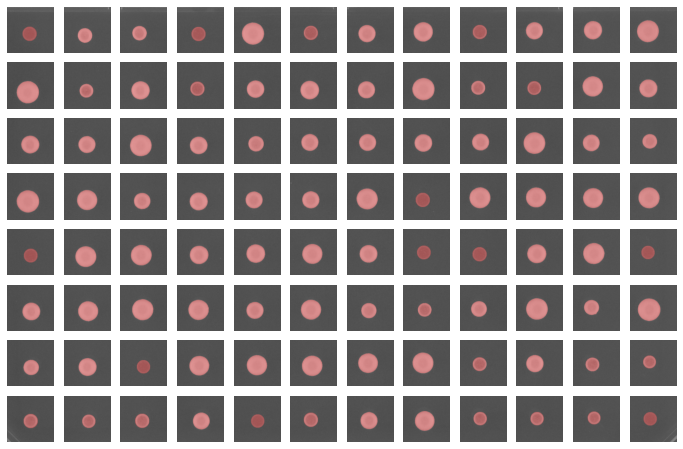

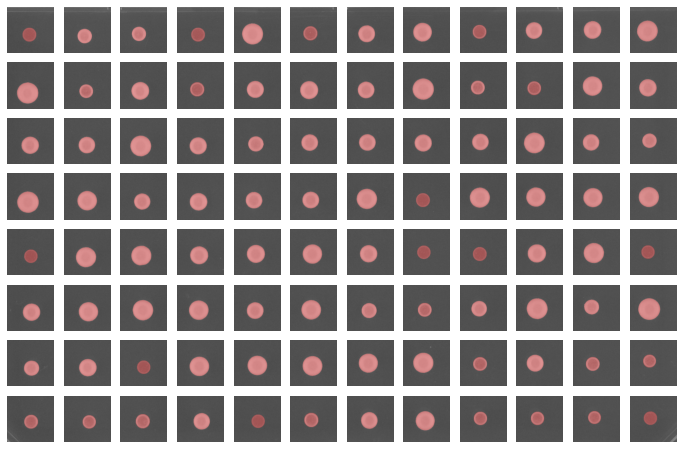

In [6]:
# -- Main processing loop
# loop through file names in list of images and load image, crop to regions of interest, 
# segment patch from background agar in each ROI, and then save results
# Displays segmented ROIs to the screen as processed.

for i in range(0,len(my_list)):
    flag = False
    cell_plate = skimage.io.imread(my_list[i])
    filename = my_list[i].split('.')[0]+'.csv'

    cell_plate_cropped_gray = skimage.color.rgb2gray(cell_plate[520:2240,750:3400])
    crop_locs_x = np.arange(0,2240-520,214)
    crop_locs_y = np.arange(0,3400+120-(750+120),215)

    tiles = []
    for j in range(0,len(crop_locs_x)-1):
        row = cell_plate_cropped_gray[np.int(crop_locs_x[j]):np.int(crop_locs_x[j+1]):1,:]
        for jj in range(0,len(crop_locs_y)-1):
            cropped_section = row[:,np.int(crop_locs_y[jj]):np.int(crop_locs_y[jj+1]):1]
            tiles.append(cropped_section)
            
    colony_masks, clean_tiles, labeled_image, thresholds = SegmentTiles(tiles)    
    area_list, pixel_sum_list, intden_list, perimeter_list, background = SizeFeatures(clean_tiles, 
                                                                                colony_masks, tiles)
    AvgInt = np.ndarray.tolist(np.array(intden_list)/np.array(area_list))
    
    data = ({'Position':  positions, 'Area': area_list, 'AvgInt': AvgInt, 'IntDen': intden_list,})
    df = (pd.DataFrame(data, columns = ['Position','Area','AvgInt','IntDen']))
    (df.to_csv(os.path.join(output_folder,filename), index=False))
    area_array = np.reshape(area_list, (8,12))
    # -- Check for adjacent identical values in columns
    for j in range(0,12):
        col1 = area_array[0:-1,j]
        col2 = area_array[1:,j]
        diff = list(col1-col2)
        for jj in range(0,5):
            if diff[jj]==0 and diff[jj+1]==0 and diff[jj+2]==0:
                flag = True

    # -- Display heat map and file name if yes
    if flag:
        print(filename)
        print('identical neighbors in image '+str(i))
    DisplayTiles(labeled_image)
    img_seg = 255*MergeTiles(labeled_image, crop_locs_x, crop_locs_y)
    A = Image.fromarray(img_seg.astype('uint8'), 'RGB')
    A.save(os.path.join(output_folder,filename.split('.')[0]+'_seg.jpg'))

### 4. Check which images are missing

In [ ]:
# Check which images, if any, are missing 
os.chdir(r'C:\Users\Katherine\Desktop')
path = Path(os.getcwd() + '\\' + 'output_folder')
files = os.listdir(path)
my_list2 = files

set1 = set([x.split('.')[0] for x in my_list])
set2 = set([x.split('.')[0] for x in my_list2])
set1-set2

Images to be re-run with different initial crop locations for pre-processing all came from Day 3:

* Plates 1-19: 10,12,13,14,21,22,23,39
* Plates 20-38: 6,7,24,25,26,33,35, 45,46,47,51,52,53
* Plates 39-64: 21, 22, 45, 46, 47, 48, 49, 50, 64, 65

### 5. Re-run missing images with different initial crop locations until all patches are segemented.

C:\Users\Katherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:270: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
C:\Users\Katherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:301: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19


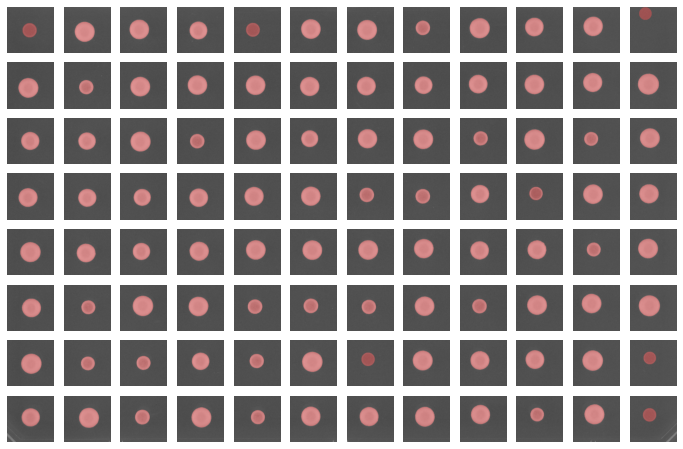

In [17]:
for i in range(7,8):
    flag = False
    cell_plate = skimage.io.imread(my_list[i])
    filename = my_list[i].split('.')[0]+'.csv'

    cell_plate_cropped_gray = skimage.color.rgb2gray(cell_plate[540:2260,750:3400])
    crop_locs_x = np.arange(0,2260-540,214)
    crop_locs_y = np.arange(0,3400+120-(750+120),215)

    tiles = []
    for j in range(0,len(crop_locs_x)-1):
        row = cell_plate_cropped_gray[np.int(crop_locs_x[j]):np.int(crop_locs_x[j+1]):1,:]
        for jj in range(0,len(crop_locs_y)-1):
            cropped_section = row[:,np.int(crop_locs_y[jj]):np.int(crop_locs_y[jj+1]):1]
            tiles.append(cropped_section)
    colony_masks, clean_tiles, labeled_image, thresholds = SegmentTiles(tiles)    
    area_list, pixel_sum_list, intden_list, perimeter_list, background = SizeFeatures(clean_tiles, 
                                                                                colony_masks, tiles)
    AvgInt = np.ndarray.tolist(np.array(intden_list)/np.array(area_list))
    
    data = ({'Position':  positions, 'Area': area_list, 'AvgInt': AvgInt, 'IntDen': intden_list,})
    df = (pd.DataFrame(data, columns = ['Position','Area','AvgInt','IntDen']))
    (df.to_csv(os.path.join(output_folder,filename), index=False))
    area_array = np.reshape(area_list, (8,12))
    # -- Check for adjacent identical values in columns
    for j in range(0,12):
        col1 = area_array[0:-1,j]
        col2 = area_array[1:,j]
        diff = list(col1-col2)
        for jj in range(0,5):
            if diff[jj]==0 and diff[jj+1]==0 and diff[jj+2]==0:
                flag = True

    # -- Display heat map and file name if yes
    if flag:
        print(filename)
        print('identical neighbors in image '+str(i))
    DisplayTiles(labeled_image)
    img_seg = 255*MergeTiles(labeled_image, crop_locs_x, crop_locs_y)
    A = Image.fromarray(img_seg.astype('uint8'), 'RGB')
    A.save(os.path.join(output_folder,filename.split('.')[0]+'_seg.jpg'))
            
    